# Import thư viện & Cấu hình hệ thống

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix



# Tắt XLA để tránh crash / OOM trên Kaggle
tf.config.optimizer.set_jit(False)

# Set seed để tái lập kết quả
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Liệt kê GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)

if gpus:
    try:
        # Set memory growth CHO TẤT CẢ GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("GPU config error:", e)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

2025-12-17 15:36:32.660129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765985793.241707      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765985793.391715      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765985794.629913      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765985794.629965      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765985794.629968      24 computation_placer.cc:177] computation placer alr

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
from tensorflow import keras
from tensorflow.keras import layers, Model

# ResNet50 + preprocess_input (BẮT BUỘC đi chung)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Callbacks để train ổn định & tối ưu
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# Khai báo đường dẫn dataset & Tham số training

In [3]:
DATASET_PATH = "/kaggle/input/animals-10-enhanced/dataset"

TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR   = os.path.join(DATASET_PATH, "val")
TEST_DIR  = os.path.join(DATASET_PATH, "test")

# Lấy danh sách class
class_names = sorted(next(os.walk(TRAIN_DIR))[1])
NUM_CLASSES = len(class_names)

print("Số lớp:", NUM_CLASSES)
print("Classes:", class_names)

# Image config
IMG_SIZE = 224

# Batch size cho từng phase
BATCH_SIZE_PHASE1 = 32
BATCH_SIZE_PHASE2 = 16  # fine-tune nên nhỏ hơn

# Epochs cho từng phase
EPOCHS_PHASE1 = 40
EPOCHS_PHASE2 = 70

Số lớp: 10
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


# Load dữ liệu – Train / Val / Test

In [4]:
# Data augmentation cho TRAIN
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation & Test: KHÔNG augmentation
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# ===== Phase 1: Train head =====
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE_PHASE1,
    class_mode="sparse",
    shuffle=True,
    seed=SEED
)

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE_PHASE1,
    class_mode="sparse",
    shuffle=False
)

# ===== Test set =====
test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE_PHASE1,
    class_mode="sparse",
    shuffle=False
)


Found 33917 images belonging to 10 classes.
Found 3903 images belonging to 10 classes.
Found 3914 images belonging to 10 classes.


# Xây dựng Model ResNet50
## Build ResNet50 (Phase 1) 

In [5]:
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze toàn bộ backbone
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Preprocess trong graph (BEST PRACTICE)
x = preprocess_input(inputs)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)

model.summary()

I0000 00:00:1765985857.200422      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765985857.204365      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     20,490 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,616,394 (90.09 MB)

 Trainable params: 24,586 (96.04 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

## Compile model (Phase 1)

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-3
    ),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

## Callbacks Phase 1

In [7]:
callbacks_phase1 = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

## Train Phase 1


In [8]:
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks_phase1,
    verbose=2
)

model.save("resnet50_phase1.keras")
print(">> Saved: resnet50_phase1.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1765985869.844849      88 service.cc:152] XLA service 0x7fac7c04e220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765985869.844884      88 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765985869.844888      88 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765985871.984245      88 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1765985878.107574      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1060/1060 - 721s - 680ms/step - accuracy: 0.7308 - loss: 0.9121 - val_accuracy: 0.9044 - val_loss: 0.2964 - learning_rate: 1.0000e-03
Epoch 2/40
1060/1060 - 454s - 429ms/step - accuracy: 0.7839 - loss: 0.7186 - val_accuracy: 0.9152 - val_loss: 0.2781 - learning_rate: 1.0000e-03
Epoch 3/40
1060/1060 - 455s - 430ms/step - accuracy: 0.7918 - loss: 0.6889 - val_accuracy: 0.9167 - val_loss: 0.2660 - learning_rate: 1.0000e-03
Epoch 4/40
1060/1060 - 456s - 430ms/step - accuracy: 0.7953 - loss: 0.6767 - val_accuracy: 0.9206 - val_loss: 0.2543 - learning_rate: 1.0000e-03
Epoch 5/40
1060/1060 - 452s - 426ms/step - accuracy: 0.7988 - loss: 0.6619 - val_accuracy: 0.9178 - val_loss: 0.2593 - learning_rate: 1.0000e-03
Epoch 6/40
1060/1060 - 459s - 433ms/step - accuracy: 0.7958 - loss: 0.6587 - val_accuracy: 0.9165 - val_loss: 0.2613 - learning_rate: 1.0000e-03
Epoch 7/40

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1060/1060 - 451s - 426ms/step - accuracy: 0.8029 - l

# Phase 2 – Fine-tune ResNet50
## Unfreeze backbone & freeze BatchNorm

In [9]:
base_model.trainable = True

# Fine-tune ~60% backbone (mạnh hơn 30%)
fine_tune_at = int(len(base_model.layers) * 0.4)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Freeze BatchNorm layers (RẤT QUAN TRỌNG)
for layer in model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

print(f"🔧 Fine-tuning từ layer {fine_tune_at}/{len(base_model.layers)}")

🔧 Fine-tuning từ layer 70/175


## Re-compile với LR cao hơn (cho phép học)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=2e-5   # ↑ từ 8e-6 → 2e-5
    ),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     20,490 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,616,394 (90.09 MB)

 Trainable params: 22,385,930 (85.40 MB)

 Non-trainable params: 1,230,464 (4.69 MB)

## Data generator cho Phase 2 

In [11]:
train_data_phase2 = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE_PHASE2,
    class_mode="sparse",
    shuffle=True,
    seed=SEED
)

val_data_phase2 = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE_PHASE2,
    class_mode="sparse",
    shuffle=False
)

Found 33917 images belonging to 10 classes.
Found 3903 images belonging to 10 classes.


## Callbacks Phase 2

In [12]:
callbacks_phase2 = [
    ModelCheckpoint(
        filepath="resnet50_phase2_best.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=4,
        factor=0.3,
        min_lr=1e-6,
        verbose=1
    )
]

## Train Phase 2

In [13]:
history2 = model.fit(
    train_data_phase2,
    validation_data=val_data_phase2,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    verbose=2
)

model.save("resnet50_phase2.keras")
print(">> Saved: resnet50_phase2.keras")

Epoch 1/70

Epoch 1: val_loss improved from inf to 0.10628, saving model to resnet50_phase2_best.keras
2120/2120 - 531s - 251ms/step - accuracy: 0.8683 - loss: 0.4059 - val_accuracy: 0.9675 - val_loss: 0.1063 - learning_rate: 2.0000e-05
Epoch 2/70

Epoch 2: val_loss improved from 0.10628 to 0.08296, saving model to resnet50_phase2_best.keras
2120/2120 - 477s - 225ms/step - accuracy: 0.9191 - loss: 0.2423 - val_accuracy: 0.9751 - val_loss: 0.0830 - learning_rate: 2.0000e-05
Epoch 3/70

Epoch 3: val_loss improved from 0.08296 to 0.07389, saving model to resnet50_phase2_best.keras
2120/2120 - 473s - 223ms/step - accuracy: 0.9404 - loss: 0.1768 - val_accuracy: 0.9800 - val_loss: 0.0739 - learning_rate: 2.0000e-05
Epoch 4/70

Epoch 4: val_loss improved from 0.07389 to 0.07228, saving model to resnet50_phase2_best.keras
2120/2120 - 472s - 223ms/step - accuracy: 0.9527 - loss: 0.1389 - val_accuracy: 0.9795 - val_loss: 0.0723 - learning_rate: 2.0000e-05
Epoch 5/70

Epoch 5: val_loss improved f

# Statistical
## Evaluate on test set

In [14]:


test_loss, test_acc = model.evaluate(test_data, verbose=1)

print(f"🧪 Test Loss: {test_loss:.4f}")
print(f"🧪 Test Accuracy: {test_acc:.4f}")


123/123 ━━━━━━━━━━━━━━━━━━━━ 51s 400ms/step - accuracy: 0.9795 - loss: 0.0997
🧪 Test Loss: 0.1146
🧪 Test Accuracy: 0.9755


## Plot learning curves

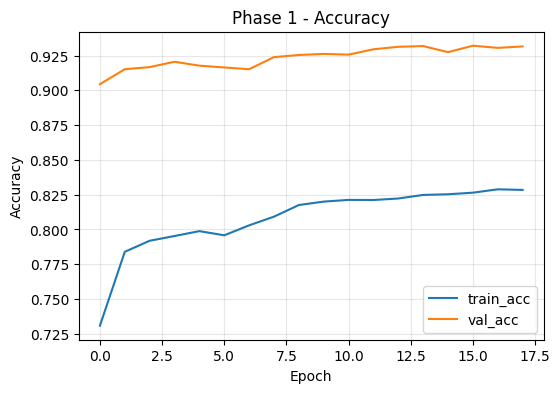

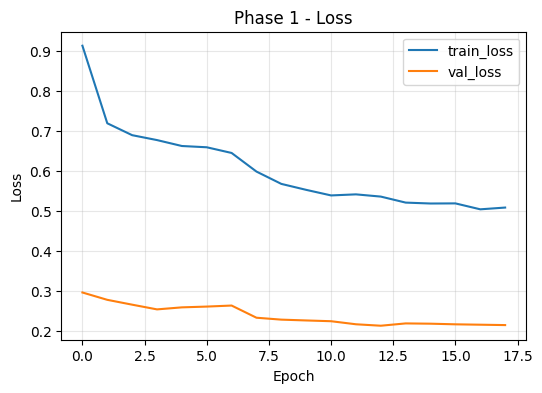

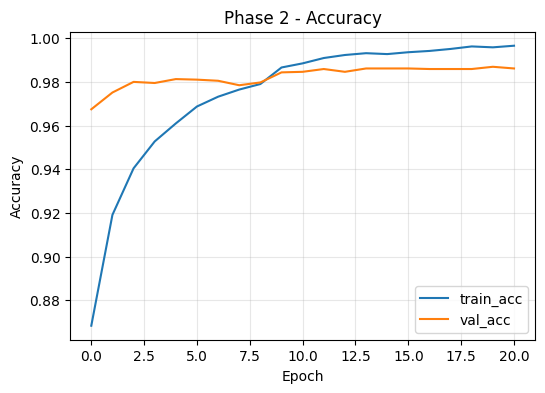

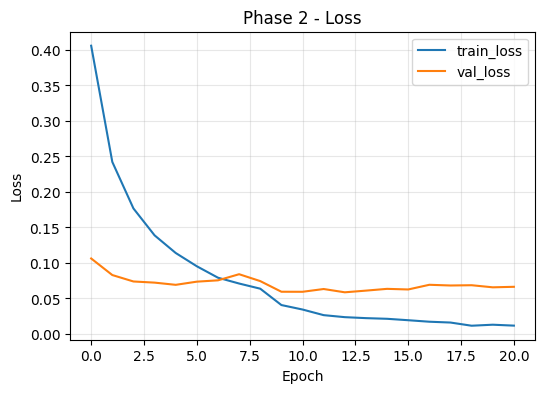

In [15]:
def plot_history(history, title):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_history(history1, "Phase 1")
plot_history(history2, "Phase 2")